In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
# model configuration
model_path = './save/edsr-baseline-lte-warp.pth'

# image configuration
in_path = './demo/Urban100_img092_warp.png'
tf_path = './demo/Urban100_img092_warp.pth'
gt_path = './demo/Urban100_img092.png'
xx = 270
yy = 425
obs_size = 60

In [3]:
import models
import utils

from torchvision import transforms
from PIL import Image

# load model
model_spec = torch.load(model_path)['model']
model = models.make(model_spec, load_sd=True).cuda()

# load image
img_in = transforms.ToTensor()(Image.open(in_path).convert('RGB'))
img_gt = transforms.ToTensor()(Image.open(gt_path).convert('RGB'))
h, w = img_in.shape[-2:]
H, W = img_gt.shape[-2:]

# load transform
transf = torch.load(tf_path)

# find xx, yy in input coordinate space
coordy = torch.stack([torch.tensor(2*xx/H + 1/H - 1), torch.tensor(2*yy/W + 1/W - 1)], dim=0).unsqueeze(0)
coordx, _ = utils.gridy2gridx_homography(coordy, H, W, h, w, transf)

xx_in = int(torch.round((coordx[0][0] + 1 - 1/h) * h / 2).item())
yy_in = int(torch.round((coordx[0][1] + 1 - 1/w) * w / 2).item())

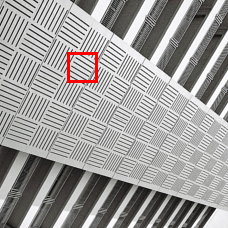

In [4]:
from PIL import ImageDraw

# Display input
im = Image.open(in_path).convert('RGB')
draw = ImageDraw.Draw(im)
draw.rectangle([yy_in-obs_size//4, xx_in-obs_size//4, yy_in+obs_size//4, xx_in+obs_size//4], outline="red", width=3)
display(im)

/home/ljw3136/anaconda3/envs/lte/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811805959/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


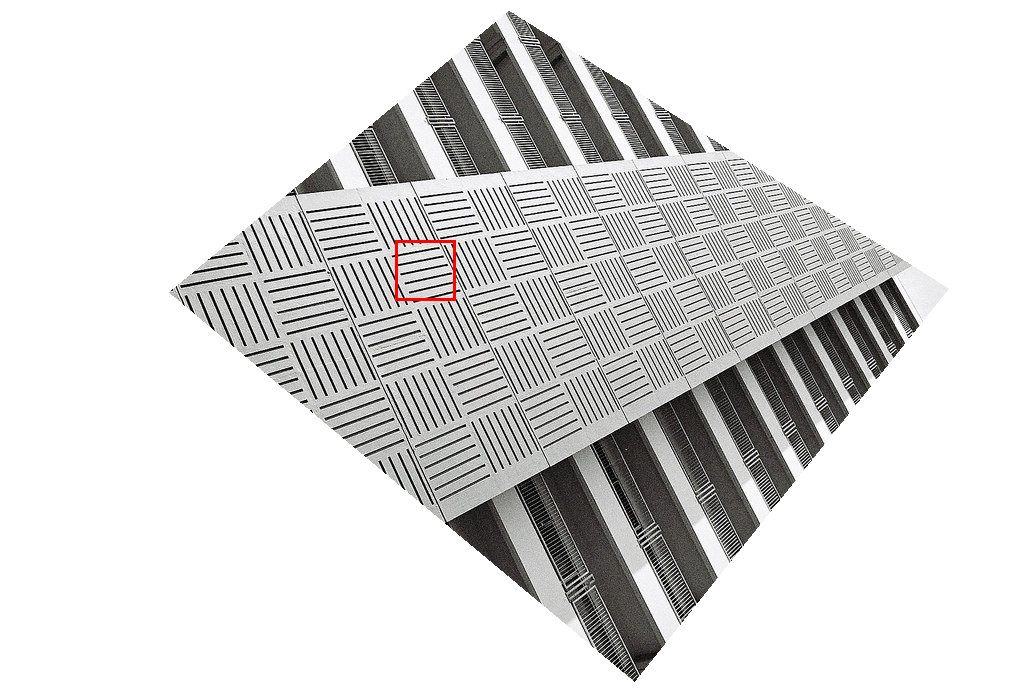

In [5]:
from PIL import ImageDraw

# find mask
coordy = utils.make_coord((H, W))
_, mask = utils.gridy2gridx_homography(coordy, H, W, h, w, transf)
mask = mask.view(H, W, 1).permute(2, 0, 1)

# Display GT
im = transforms.ToPILImage()(img_gt*mask + 1-mask)
draw = ImageDraw.Draw(im)
draw.rectangle([yy-obs_size//2, xx-obs_size//2, yy+obs_size//2, xx+obs_size//2], outline="red", width=3)
display(im)

In [6]:
# evaluation
inp = (img_in.unsqueeze(0).cuda() - 0.5) / 0.5

model.eval()
with torch.no_grad():
    model.gen_feat(inp.flip(-2))        
    freq = model.freq(model.feat).flip(-2)
    coef = model.coef(model.feat).flip(-2)

# obtain Jacobain
JacobT = utils.JacobT(transf, xx_in, yy_in, h, w)

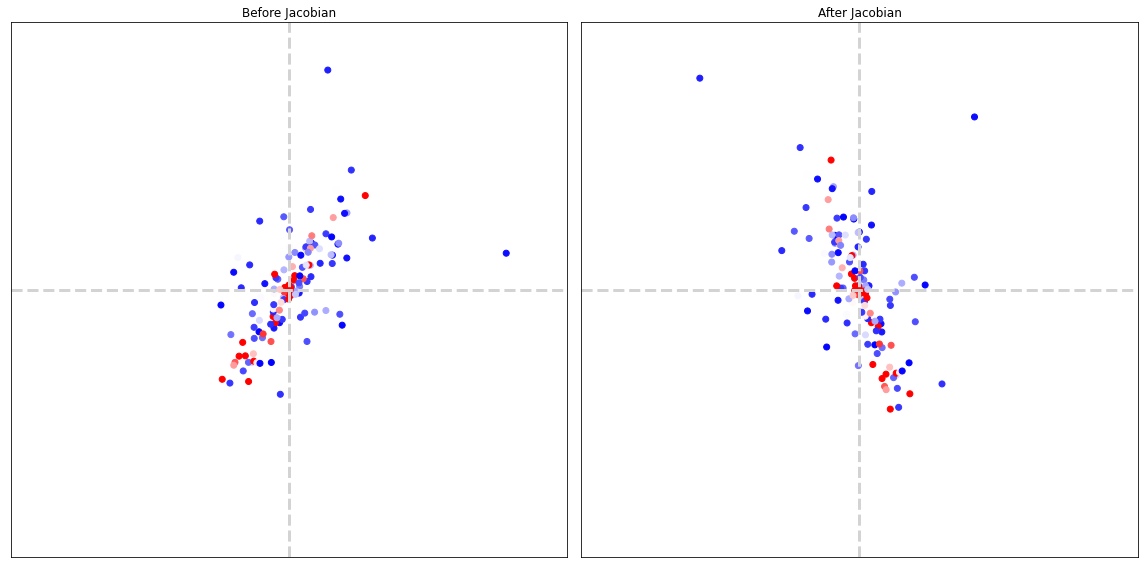

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (2*8, 8)

fig = plt.subplot(1, 2, 1)
freq_x = torch.stack(torch.split(freq, 2, dim=1), dim=2)[0, 1, :, xx_in, yy_in].cpu().numpy()
freq_y = torch.stack(torch.split(freq, 2, dim=1), dim=2)[0, 0, :, xx_in, yy_in].cpu().numpy()
mag    = (coef[0, :freq.shape[1]//2, xx_in, yy_in]**2 + coef[0, freq.shape[1]//2:, xx_in, yy_in]**2).cpu().numpy()
sc = plt.scatter(freq_x, freq_y, c=mag, vmin=0, vmax=max(mag)/4, s=None, cmap='bwr')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xticks([])
plt.yticks([])
plt.hlines(0, -1.5, 1.5, color='lightgray', linestyle='--', linewidth=3)
plt.vlines(0, -1.5, 1.5, color='lightgray', linestyle='--', linewidth=3)
plt.title('Before Jacobian')

fig = plt.subplot(1, 2, 2)
freq_x = torch.stack(torch.split(freq, 2, dim=1), dim=2)[0, 1, :, xx_in, yy_in].cpu()
freq_y = torch.stack(torch.split(freq, 2, dim=1), dim=2)[0, 0, :, xx_in, yy_in].cpu()
freq_w = torch.mm(JacobT, torch.stack([freq_x, freq_y], dim=0))
freq_w_x = freq_w[0].cpu().numpy()
freq_w_y = freq_w[1].cpu().numpy()
mag    = (coef[0, :freq.shape[1]//2, xx_in, yy_in]**2 + coef[0, freq.shape[1]//2:, xx_in, yy_in]**2).cpu().numpy()
sc = plt.scatter(freq_w_x, freq_w_y, c=mag, vmin=0, vmax=max(mag)/4, s=None, cmap='bwr')

plt.xlim(-1.5/2, 1.5/2)
plt.ylim(-1.5/2, 1.5/2)
plt.xticks([])
plt.yticks([])
plt.hlines(0, -1.5/2, 1.5/2, color='lightgray', linestyle='--', linewidth=3)
plt.vlines(0, -1.5/2, 1.5/2, color='lightgray', linestyle='--', linewidth=3)
plt.title('After Jacobian')

plt.tight_layout()
plt.show()